## Do We Really Want Accurate Predictions?  


### The case for cost-minimizing loss functions
<ul>
<li>Predictive models minimize loss function to find 'best fit'</li>
<li>Loss function determines cost/benefit tradeoff</li>
<li>Least squares version traditionally used when models need to be interpreted</li>
<li>In predictive analytics overall accuracy may not be as important
</ul>    

### Background on the Prudential Life Insurance Model
Principal-agent model where Prudential is the principal and the consumer (applicant) is the agent.  

Timing:
<ol>
<li>User provides info</li>
<li>Prudential categorizes user as risk category $i$ and offers price $P_i$</li>
<li>User decides whether to accept or reject offer</li>
</ol>

#### Assumptions
User:
<ul>
<li>User provides accurate information</li> 
<li>they decide whether or not to reject the offer given the price offered and their personal taste for risk.</li>  
</ul>
Prudential:
<ul>
<li>Categorize agents in a way that maximizes their profits</li>
<li>offer prices that maximize their expected profit. </li>  
</ul>

### Prudential Insurance and the Weighted Kappa Loss Function

Recent Kaggle competition on supervised learning with ordinal categories. 

Participants competed to create the best predictive model for risk categories using supervised learning.  

There were 8 risk categories, and the response variable was distributed as follows:

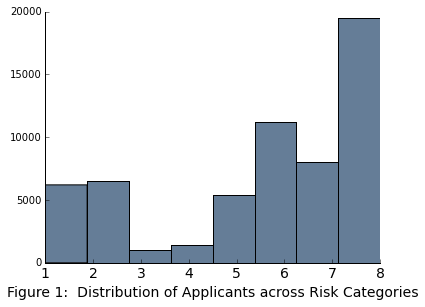

In [17]:
from numpy import loadtxt, zeros, ones, array, linspace, logspace
from pylab import scatter, show, title, xlabel, ylabel, plot, contour
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
%matplotlib inline
traindf = pd.read_csv("train.csv")

#Histogram for response variables to get an idea of distribution of risk categories
plt.figure(figsize=(6,4.5))
plt.hist(traindf['Response'],color="#657d97", bins=8)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.xlabel('Figure 1:  Distribution of Applicants across Risk Categories', fontsize=14)


Based on data analysis, risk category 1 appears to be 'riskiest' category, risk categoy 8 'least risky'.  Categories are ordinal

Bi-modal distribution of category assignments likely result of people selecting whether or not to apply for insurance

Mortality risk often assumed to follw the Weibull distribution with $\lambda$ = 1, as below:


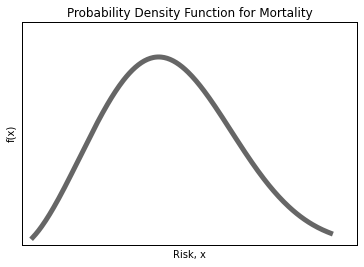

In [18]:
from scipy.stats import weibull_min
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')

#Plot the pdf for mortality using the weibull distribution
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 300)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.xlabel('Risk, x')
plt.ylabel('f(x)')
plt.show()

For the purposes of our discussion, we'll assume that the expected cost of an insurance policy is linear in the risk of the customer.  Individuals with a risk factor of 2.0 have twice the expected cost of those with a risk factor of 1.0.  Prudential's risk categories can then be modelled as a series of risk cutoffs, cutting the distribution into eight equally sized risk segments.  Note that the lowest risk category (risk category 8) necessarily captures the extended right tail of the distribution.  

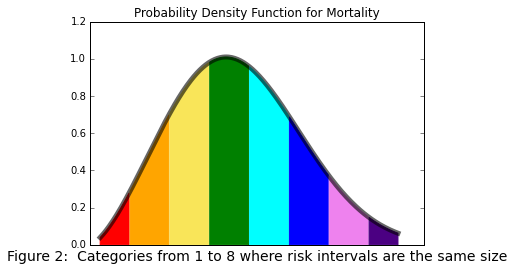

In [19]:
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')

# cutoffs = frange(0.0,3.0,(i+1)/3)
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 300)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
pColor = ['b']
i=0
cutoff = []
for i in range(9):
    cutoff.append(i/4.2)
pColor = ['red','orange','#F9E559','green','cyan','blue','violet','indigo']
for i in range(8):
    lb = cutoff[i]
    ub = cutoff[i+1]

    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 2:  Categories from 1 to 8 where risk intervals are the same size', fontsize=14)
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.show()

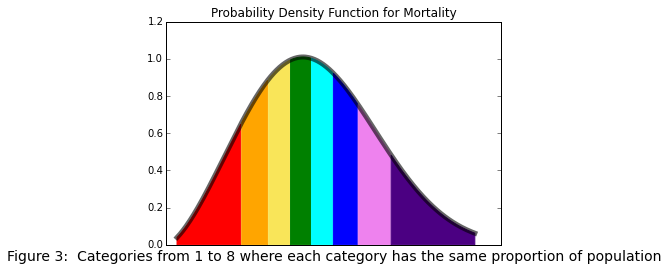

In [20]:
cutoffs = []
for i in range(7):
    cutoffs.append((i+1)/8.0)

#Conduct a binary search to find eight equally likely intervals for our Weibull distribution:
riskCutoffs = [0]
for cutoff in cutoffs:
    Low = 0.0
    High = 4.0
    epsilon = 0.001
    while True:
        guess = (Low + High) / 2
        diff = weibull_min.cdf(guess,c) - cutoff
        if diff<0 and abs(diff)>epsilon:
            Low = guess
        elif diff>0 and abs(diff)>epsilon:
            High = guess
        else:
            riskCutoffs.append(guess)
            break
riskCutoffs.append(4.0)

#Graph distribution with categories shaded (categories go from 1 to 8, left to right)
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 300)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)

for i in range(8):
    lb = riskCutoffs[i]
    ub = riskCutoffs[i+1]
    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 3:  Categories from 1 to 8 where each category has the same proportion of population', fontsize=14)
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.show()

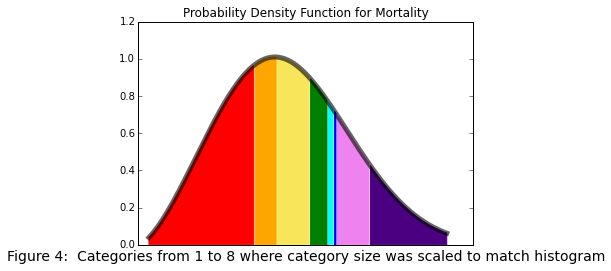

In [21]:
#Find the number of observations in each category and find the cumulative proportion from categories 1 to 8 (from most risky to least risky)
counts = traindf['Response'].value_counts()
propCounts = [0]
cumulativeCounts = []
cumulativeCount = 0
for i in range(7):
    propCount = float(counts[8-i]) / sum(counts)
    propCounts.append(propCount)
    cumulativeCount += propCount
    cumulativeCounts.append(cumulativeCount)
riskCutoffs2 = [0]

#Conduct a bisection search to find eight equally likely intervals for our Weibull distribution:
riskCutoff = 0
for cumulativeCount in cumulativeCounts[0:7]:
    Low = 0.0
    High = 3.0
    epsilon = 0.001
    while True:
        guess = (Low + High) / 2
        diff = weibull_min.cdf(guess,c) - cumulativeCount
        if diff<0 and abs(diff)>epsilon:
            Low = guess
        elif diff>0 and abs(diff)>epsilon:
            High = guess
        else:
            riskCutoffs2.append(guess)
            break
riskCutoffs2.append(4.0)

#Graph distribution with categories shaded (categories go from 1 to 8, left to right)
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 200)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
for i in range(8):
    lb = riskCutoffs2[i]
    ub = riskCutoffs2[i+1]
    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 4:  Categories from 1 to 8 where category size was scaled to match histogram', fontsize=14)
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.show()

Categories 3 and 4 (cyan and blue) are very small, unlikely to be due to design of categories, likely due instead to self-selection amongst population in those categories


### The quadratic weighted kappa loss function and Economic Efficiency

Kaggle Challenge - Quadratic weighted kappa loss function used to measure 'best fit'

$$ \kappa = 1 - \frac{\sum_{i,j}w_{i,j}O_{i,j}}{\sum_{i,j}w_{i,j}E_{i,j}}$$

$w_{i,j}$ puts a greater weight on predictions further from the actual risk category, 
For any two categories $i$ and $j$ is the squared difference between the two, discounted by the number of categories, the weight is zero for when categories $i$ and $j$ are the same (i.e. accurate predictions).  

$O_{i,j}$ is a count of the number of observations that were actually category $i$ but were predicted to be category $j$.  

$E_{i,j}$ is the total number of observations predicted to be in category $j$ multiplied by the actual number of observations in category $i$, and accounts for how accurate you would be if you had randomly assigned predictions.  

Model with the highest value of $\kappa$ is considered the 'best fit'.

Two main areas where the quadratic weighted kappa loss function loses efficiency
<ol>
<li>weights all deviations from actual predictions the same regardless of the actual prediction. </li>
<li>The second is that deviations are treated symmetrically, predicting one category lower than the actual risk bears the same penalty as predicting one category higher than actual risk.  </li>
</ol>

### Equal treatment across actual risk levels.
The weighted kappa loss function penalizes an $n$-category deviation from actual risk category 4 the same as they would an $n$-category deviation from actual risk category 1.  

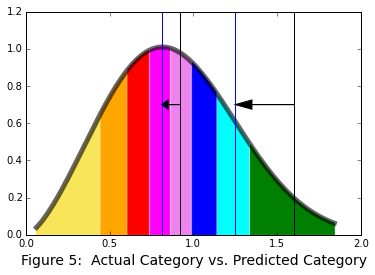

In [22]:
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 200)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
pColor = ['#F9E559','orange','red','magenta','violet','blue','cyan','green']

for i in range(8):
    lb = riskCutoffs[i]
    ub = riskCutoffs[i+1]
    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 5:  Actual Category vs. Predicted Category', fontsize=14)
plt.plot((1.6, 1.6), (0, 1.2), 'k-')
plt.plot((1.25, 1.25), (0, 1.2), 'b-')
ax.arrow(1.6, 0.7, -0.25, 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.arrow(0.92, 0.7, -0.07, 0, head_width=0.05, head_length=0.04, fc='k', ec='k')


plt.plot((0.92, 0.92), (0, 1.2), 'k-')
plt.plot((0.81, 0.81), (0, 1.2), 'b-')
plt.show()

The cost of a 1-category error is much larger when the actual risk category is 8 than if the actual risk category is 5.

### Symmetric treatment of errors
Errors are treated symmetrically, a prediction of 5 when the actual category is 4 has the same penalty as a prediction of 3 when the actual category is 4.  

With insurance the direction of the error is very important.  
<ul>
<li>Prediction determines the revenue (price) for the company, provided the consumer buys the policy.</li>  <li>Actual risk category determines the cost to the company.</li>  
</ul>

Prediction of higher than actual risk (lower risk category) leads to a higher price, eventually consumer will not buy the policy, and loss is constant.

Prediction of lower than actual risk (higher risk category) leads to a lower price due to lower predicted risk, loss of the difference in price between the two categories, loss increasing in size error

Control for these differences by altering the weight matrix for the weighted kappa, so that the weight matrix truly represents the expected cost for each deviation.  Given our assumptions, the weight matrix should look something like the following:

<img src="weight_table.png">

Here $L_i$ is the foregone profit Prudential could have made from predicting the risk category accurately (if $i$=3 this foregone profit is the price of an insurance policy for someone with risk category 3 less the expected cost of someone in risk category 3).   $P_i$ is the price of an insurance policy for womeone with risk category $i$.  

In Conclusion, choice of loss function is fundamental when doing predictive analytics.  